# The example of development, training, and use of a simple neural network to read handwritten digits

Luca Mari, June 2024

This work is licensed under CC BY-NC-SA 4.0. To view a copy of this license, visit https://creativecommons.org/licenses/by-nc-sa/4.0.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

[the files of this activity: [mnist_en.ipynb](mnist_en.ipynb), [mnistutils_en.py](mnistutils_en.py)]

**Purpose**: to understand the structure of a simple neural network, its training, and its use, as specified in Python by means of a high level module like `PyTorch`.    
**Precompetences**: bases of Python (Python code below is usually simple, given that details are usually hidden in custom functions).

> **Requirements**
> To execute this notebook -- let us suppose with VSCode --:
> * install a Python interpreter
> * install (from https://code.visualstudio.com/download) VSCode
> * run VSCode and activate its Python and Jupyter extensions
> * in VSCode:
>    * create a folder and make it the current directory
>    * copy this notebook in the folder e open it
>    * create a virtual environment (Select Kernel | Python Environments | Create Python Environment | Venv, and choose a Python interpreter):
>    * install the required Python modules:  
>        `pip install torch torchvision torchsummary numpy matplotlib`

<a name="s1"></a>
### 1. The dataset

The network we are going to build will have to learn to recognize handwritten digits, and therefore, concretely, to classify images of handwritten digits into categories, each relating to one of the 10 digits. For this we will use both for training and for the operation of the network [the MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), in which each image, digitized in a matrix of 28x28 points in which a each point is associated with a color in the gray scale, is the image of a digit.

After importing the required Python modules, we load the images of the MNIST dataset, distinguishing between _training set_ and _test set_ (the first time the files with the images will be downloaded from the web and copied to a local folder).

In [5]:
from mnistutils_en import load_data, show_images, train_loop, test_loop, test_with_prob, test_loop_with_trace 
import torch
from torch import nn

train_data, test_data = load_data()

print(f"Number of images in the training set: {len(train_data)}")
print(f"Number of images in the test set: {len(test_data)}")

Number of images in the training set: 60000
Number of images in the test set: 10000


We can show some examples of the images of the digits we want to train the network to recognize, together with the label of the correct digit, information also contained in the files we downloaded.

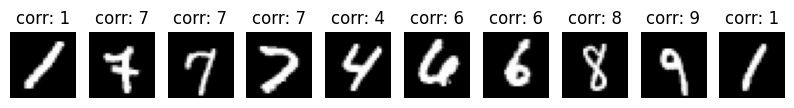

In [8]:
show_images(train_data)

The variety and irregularity of the handwriting in these images suggest that devising an algorithm to solve our classification problem and then implementing it in a program could be extremely complex, as indeed confirmed by the limited results obtained by software systems developed according to this strategy.

Let us instead try to solve the problem with the logic of _machine learning_, building and then training an artificial neural network. We will do this by means of a network with a very simple structure (a _fully connected_ network, or _MultiLayer Perceptron_, MLP).

<a name="s2"></a>
### 2. A *MultiLayer Perceptron*

Let us start designing the network according to the simplest option, that is, as a *MultiLayer Perceptron*, by defining a class that inherits from `torch.Module` and initializing the layers of the network in the class constructor:
* the input layer contains 28*28 neurons, that is, one for each point of an image, each of them connected to each of the neurons of the first hidden layer;
* the first hidden layer contains 512 neurons, each of them connected to each of the neurons of the second hidden layer;
* the second hidden layer contains 512 neurons, each of them connected to each of the neurons of the output layer;
* the output layer contains 10 neurons, one for each category in which to classify an image, and therefore one for each possible recognizable digit.

This is then the structure of the network:  

![net](mnist_en.drawio.svg)

Every time we run this network by feeding it an image to classify, and then assigning a value to each of the 28x28 neurons in the input layer, we will get a value for each of the 10 neurons in the output layer, where the set of these 10 values ​​is a probability distribution that represents the inferential information produced by the network about the probability that the digit in the image is a 0, or a 1, and so on.

Along with its constructor `__init__`, we implement in the class the method `forward`, which performs the operations that must be computed on the input data.

We then create the network by instantiating the class. At this point the parameters of the network are initialized as random values.

In [10]:
class MLP_NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(   # Sequential() builds a sequence of components
            nn.Linear(28*28, 512),      # Linear(x, y) builds the connection among all x neurons of the first layer and all y neurons of the second layer
            nn.ReLU(),                  # ReLU() sets ReLu (rectified linear unit) as the activation function of the output signal of each neuron
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = nn.Flatten()(x)             # Flatten() makes the input unidimensional, thus adapting the images to the input layer
        return self.network(x)
    
network = MLP_NN()

num_MLP_params = sum(p.numel() for p in network.parameters())
print(f"This is a network with {num_MLP_params} parameters.")

This is a network with 669706 parameters.


We can already ask this network for a prediction, even before we have trained it and therefore, as we said, with its parameters initialized as random values, but obviously we will not get anything useful from it. This can be seen by comparing the predicted digit ("pred") and the correct one ("corr") for a randomly chosen image, in which as the predicted digit we choose the one with the highest probability in the distribution resulting from the inference, i.e., the mode of the distribution. And in fact the distribution we obtain is almost uniform, i.e., it is in conditions of "minimum information" (and therefore of maximum entropy), indicating that the network can already be made to work but, without training, it is not yet able to effectively recognize digits.

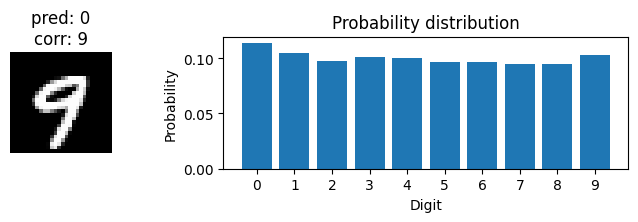

In [14]:
test_with_prob(test_data, network)

<a name="s3"></a>
### 3. Training the network

In order to train the network, we specify values ​​for the hyperparameters, as well as the error function and the optimization function for backpropagation.

In [15]:
learning_rate = 1e-3                    # hyperparameters for training 
batch_size = 50
num_batches = 500
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

We finally train the network according to these hyperparameters and, at the same time, put it to the test, in order to evaluate whether it is really learning to correctly classify the images we submit.

Epoch	Accuracy
1	14.0%
2	26.0%
3	44.0%
4	58.0%
5	52.0%
6	66.0%
7	60.0%
8	76.0%
9	72.0%
10	78.0%
11	86.0%
12	86.0%
13	68.0%
14	70.0%
15	92.0%
16	84.0%
17	80.0%
18	88.0%
19	86.0%
20	88.0%
Process completed in 32.89 seconds


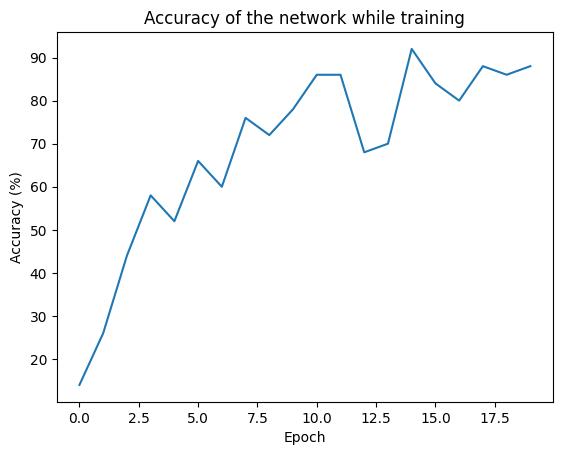

In [16]:
import time
import matplotlib.pyplot as plt

start_time = time.time()
accuracy = []
print("Epoch\tAccuracy")
for t in range(epochs):
    train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network) / batch_size * 100
    print(f"{t + 1}\t{correct:.1f}%")
    accuracy.append(correct)
end_time = time.time()

print(f"Process completed in {end_time - start_time:.2f} seconds")
plt.plot(range(epochs), accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of the network while training")
plt.show()

<a name="s4"></a>
### 4. Testing the network

Now that the network has been trained, we can evaluate quantitatively the accuracy of its predictions.

In [22]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network) /batch_size * 100
print(f"Accuracy: {correct:.1f}%")

Accuracy: 84.4%


And the same can be done by comparing the predicted ("pred") and the correct ("corr") digit for 10 random images.

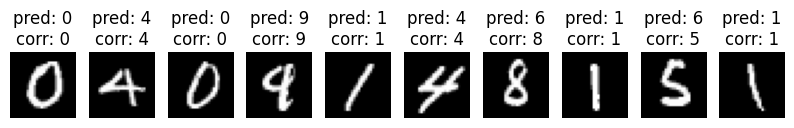

In [8]:
test_loop_with_trace(test_data, network)

In the case of a single image, we can display the probability distribution resulting from the inference, from which, as before, the predicted digit is chosen as the most probable. The effect of training is evident here: even if the structure of the network has not changed, and therefore we have not modified the network by reprogramming it, the distribution is no longer uniform, but usually with one or a few categories with high probability. In short, this significant difference in behavior is entirely due to the training to which we subjected the network.

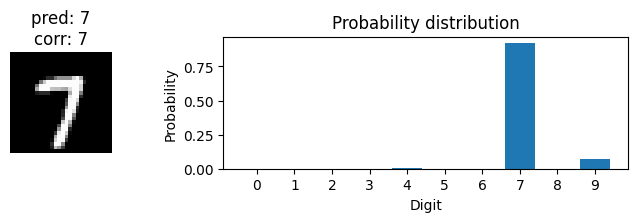

In [25]:
test_with_prob(test_data, network)

<a name="s5"></a>
### 5. Improving the classification / decision criterion

Now that we have been able to train the network, we can ask ourselves whether to refine the classification method, to take into account situations in which the probability distribution would lead to an uncertain decision, because the probability of the mode is not large enough or the difference between the two largest probabilities of the distribution is not large enough. In such cases, we could decide not to propose any prediction, and therefore to admit that the case is doubtful.  
Let us then assign a value to two new hyperparameters.

In [25]:
min_mode_prob = 0.3                         # minimum probability to consider a prediction as correct
min_diff_prob = 0.2                         # minimum difference between the two highest probabilities to consider a prediction as correct

For making this decision logic clearer, let us show the explicit Python code.

In [26]:

from torch.utils.data import DataLoader
network.eval()                              # set test mode
dataloader = iter(DataLoader(test_data, batch_size=batch_size, shuffle=True))   # create an iterator for the test set

with torch.no_grad():                       # don't compute gradients
    X, y = next(dataloader)                 # get a batch of images and labels
    logits = network(X)                     # compute the predictions as logits
pred_prob = nn.Softmax(dim=1)(logits)       # convert logits into a probability in distribution

y_pred = pred_prob.argmax(1)
corr_pred = torch.eq(y_pred, y)
print("*** Results of test wit no adjustment ***")
print(f"Accuracy: {100 * corr_pred.sum().item() / batch_size:.1f}%")
print(f"Error: {100 * (batch_size - corr_pred.sum().item()) / batch_size:.1f}%")

two_max_prob = torch.topk(pred_prob, 2).values
suff_high_prob = two_max_prob[:,0] > min_mode_prob
suff_diff_prob = (two_max_prob[:,0] - two_max_prob[:,1]) > min_diff_prob
suff_quality = suff_high_prob * suff_diff_prob
adj_corr_pred = corr_pred * suff_quality
doubtful_pred = torch.logical_not(suff_quality)
print("\n*** Results of test with adjustment ***")
print(f"(minimum probability to consider a prediction as correct: {min_mode_prob})")
print(f"(minimum difference between the two highest probabilities to consider a prediction as correct: {min_diff_prob})")
print(f"Accuracy: {100 * adj_corr_pred.sum().item() / batch_size:.1f}%")
print(f"Doubtful predictions: {100 * doubtful_pred.sum().item() / batch_size:.1f}%")
print(f"Error: {100 * (suff_quality * torch.logical_not(corr_pred)).sum().item() / batch_size:.1f}%")

*** Results of test wit no adjustment ***
Accuracy: 84.5%
Error: 15.5%

*** Results of test with adjustment ***
(minimum probability to consider a prediction as correct: 0.3)
(minimum difference between the two highest probabilities to consider a prediction as correct: 0.2)
Accuracy: 72.6%
Doubtful predictions: 23.2%
Error: 4.2%


As you can see, this adjustment reduces the accuracy, because it treats as doubtful some cases that were recognized correctly, but also the prediction error, because it treats as doubtful some cases that were recognized incorrectly.

Here are some examples of images whose classification is uncertain, according to the criteria we have established.

Examples of images whose prediction is uncertain:


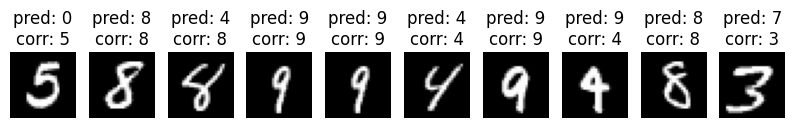

In [27]:
doubtful_data = [(X[i], y[i]) for i in range(batch_size) if doubtful_pred[i]]
print("Examples of images whose prediction is uncertain:")
test_loop_with_trace(doubtful_data, network)

Here are some examples of images whose classification is instead wrong, again according to the criteria we have established.

Examples of images whose prediction is wrong:


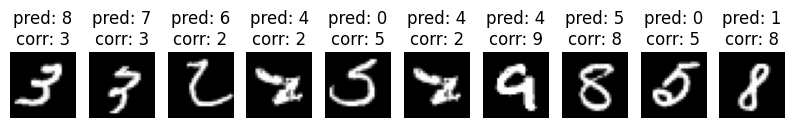

In [28]:
wrong_pred = [(X[i], y[i]) for i in range(batch_size) if (suff_quality * torch.logical_not(corr_pred))[i]]
print("Examples of images whose prediction is wrong:")
test_loop_with_trace(wrong_pred, network)


Although this network has produced fairly accurate predictions, it is not ideal for image classification. Indeed, *MultiLayer Perceptrons* (MLPs) require transforming the images to be operated on, which have a two-dimensional structure, into sequences of one-dimensional values, thus losing information on the relative position of the pixels. In addition, the efficiency of MLPs decreases as the size of the images to be analyzed increases, because the number of model parameters and therefore the computing power needed for training grows with the increase in such dimensions. Structurally better solutions can be found in the *Convolutional Neural Networks* (CNNs). 